# Predict the Energy Star Score of Buildings Part 2

In this series of notebooks, we are working on a supervised, regression machine learning problem. Using real-world New York City building energy data, we want to predict the Energy Star Score of a building and determine the factors that influence the score.

We are using the general outline of the machine learning pipeline to structure our project:

1. Understanding the Business Problem
2. Data cleaning and formatting
2. Exploratory data analysis
4. Feature engineering and selection
5. Establish a baseline and compare several machine learning models on a performance metric
6. Perform hyperparameter tuning on the best model to optimize it for the problem
7. Evaluate the best model on the testing set
8. Interpret the model results to the extent possible
9. Draw conclusions and write a well-documented report

The first notebook covered steps 1-4, and in this notebook, we will cover 5-7. In this series, I focus more on the implementations rather than the details

We will use the standard data science and machine learning libraries: `numpy`, `pandas`, and `scikit-learn`. We also use `matplotlib` and `seaborn` for visualization.

In [43]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [44]:
#!pip install scikit-learn==0.21.2

In [45]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler



In [46]:
from sklearn.preprocessing import imputation

In [47]:
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read in Data

First let's read in the formatted data from the previous notebook using Python's 'Pandas' library. 

In [48]:
# Read in data into dataframes 
train_features = pd.read_csv('E:/Data Science class/Projects/training_features.csv')
test_features = pd.read_csv('E:/Data Science class/Projects/testing_features.csv')
train_labels = pd.read_csv('E:/Data Science class/Projects/training_labels.csv')
test_labels = pd.read_csv('E:/Data Science class/Projects/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


As a reminder, here is what the formatted data looks like. In the first notebook, we engineered a number features by taking the natural log of the variables, included two categorical variables, and selected a subset of features by removing highly collinear features. 

In [49]:
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

The `score` column contains the Energy Star Score, the target for our machine learning problem. The Energy Star Score is supposed to be a comparitive measurement of the energy efficiency of a building, although we saw there may be issues with how this is calculated in part one! 

Here's the distribution of the Energy Star Score.

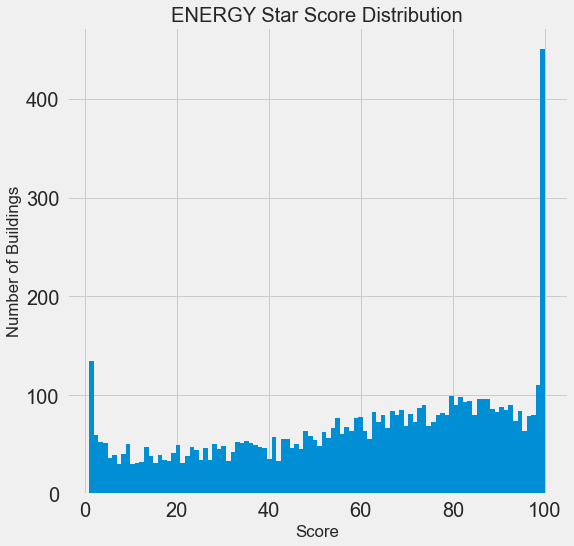

In [50]:
figsize(8, 8)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('ENERGY Star Score Distribution');

# Evaluating and Comparing Machine Learning Models

In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning). 

We are comparing models using the __mean absolute error__. A baseline model that guessed the median value of the score was off by an __average of 25 points__. 

Various ways to evaluate a machine learning model's performance are as below -

1.Confusion matrix.
2.Accuracy.
3.Precision.
4.Recall.
5.Specificity.
6.F1 score.
7.Precision-Recall or PR curve.
8.ROC (Receiver Operating Characteristics) curve.

## Imputing Missing Values

Standard machine learning models cannot deal with missing values, and which means we have to find a way to fill these in or disard any features with missing values. Since we already removed features with more than 50% missing values in the first part, here we will focus on filling in these missing values, a process known as [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)). There are a number of methods for imputation but here we will use the relatively simple method of replacing missing values with the median of the column. ([Here is a more thorough discussion on imputing missing values](http://www.stat.columbia.edu/~gelman/arm/missing.pdf))

In the code below, we create a [Scikit-learn `Imputer` object](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to fill in missing values with the median of the column. Notice that we train the imputer (using the `Imputer.fit` method) on the training data but not the testing data. We then transform (using `Imputer.transform`) both the training data and testing data. This means that the missing values in the testing set are filled in with the median value of the corresponding columns in the training set. [We have to do it this way](https://stackoverflow.com/a/46692001) rather than because at deployment time, we will have to impute the missing values in new observations based on the previous training data. This is one way to avoid the problem known as [data leakage](https://www.kaggle.com/dansbecker/data-leakage) where information from the testing set "leaks" into the training process.

Imputation preserves all cases by replacing missing data with an estimated value based on other available information. Once all missing values have been imputed, the data set can then be analysed using standard techniques for complete data.

Seven Ways to Make up Data: Common Methods to Imputing Missing Data -

Mean imputation,
Substitution,
Hot deck imputation,
Cold deck imputation,
Regression imputation,
Stochastic regression imputation,
Interpolation and extrapolation

Statistical guidance articles have stated that bias is likely in analyses with more than 10% missingness and that if more than 40% data are missing in important variables then results should only be considered as hypothesis generating 

Pandas treat None and NaN as essentially interchangeable for indicating missing or null values.

To facilitate this convention, there are several useful functions for detecting, removing, and replacing null values in Pandas DataFrame :

1. isnull()
2. notnull()
3. dropna()
4. fillna()
5. replace()
6. interpolate()

In [51]:
!pip install impyute
from impyute.imputation.cs import mice
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

In [52]:
imputer = IterativeImputer(GradientBoostingRegressor())
# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [53]:
# Create an imputer object with a median filling strategy
#imputer = Imputer(strategy='median')

# Train on the training features
#imputer.fit(train_features)

# Transform both training data and testing data
#X = imputer.transform(train_features)
#X_test = imputer.transform(test_features)

In [54]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [55]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


After imputation, all of the features are real-valued. For more sophisticated methods of imputation (although median values usually works well) check out [this article](https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146)

### Scaling Features

The final step to take before we can build our models is to [scale the features](https://en.wikipedia.org/wiki/Feature_scaling). This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm. [Linear Regression and Random Forest do not require feature scaling](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data), but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms. 

There are two ways to [scale features](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html):

1. For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.
2. For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization.

Here is a good article about [normalization and standardization](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/).

As with imputation, when we train the scaling object, we want to use only the training set. When we transform features, we will transform both the training set and the testing set.

Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

Methods

A) Rescaling (min-max normalization)

Also known as min-max scaling or min-max normalization, is the simplest method and consists in rescaling the range of features to scale the range in [0, 1] or [−1, 1]. Selecting the target range depends on the nature of the data. The general formula for a min-max of [0, 1] is given as:

 x'={\frac {x-{\text{min}}(x)}{{\text{max}}(x)-{\text{min}}(x)}}}x'={\frac  {x-{\text{min}}(x)}{{\text{max}}(x)-{\text{min}}(x)}}

where {\displaystyle x}x is an original value, {\displaystyle x'}x' is the normalized value. For example, suppose that we have the students' weight data, and the students' weights span [160 pounds, 200 pounds]. To rescale this data, we first subtract 160 from each student's weight and divide the result by 40 (the difference between the maximum and minimum weights).

To rescale a range between an arbitrary set of values [a, b], the formula becomes:

 x'=a+{\frac {(x-{\text{min}}(x))(b-a)}{{\text{max}}(x)-{\text{min}}(x)}}}{\displaystyle x'=a+{\frac {(x-{\text{min}}(x))(b-a)}{{\text{max}}(x)-{\text{min}}(x)}}}

where {\displaystyle a,b}a,b are the min-max values.

B) Mean normalization

 x'={\frac {x-{\text{average}}(x)}{{\text{max}}(x)-{\text{min}}(x)}}}{\displaystyle x'={\frac {x-{\text{average}}(x)}{{\text{max}}(x)-{\text{min}}(x)}}}

where {\displaystyle x}x is an original value, {\displaystyle x'}x' is the normalized value. There is another form of the means normalization which is when we divide by the standard deviation which is also called standardization.

C) Standardization (Z-score Normalization)

In machine learning, we can handle various types of data, e.g. audio signals and pixel values for image data, and this data can include multiple dimensions. Feature standardization makes the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance. This method is widely used for normalization in many machine learning algorithms (e.g., support vector machines, logistic regression, and artificial neural networks).[2][citation needed] The general method of calculation is to determine the distribution mean and standard deviation for each feature. Next we subtract the mean from each feature. Then we divide the values (mean is already subtracted) of each feature by its standard deviation.

 x'={\frac {x-{\bar {x}}}{\sigma }}}x' = \frac{x - \bar{x}}{\sigma}

Where {\displaystyle x}x is the original feature vector, {\displaystyle {\bar {x}}={\text{average}}(x)}{\displaystyle {\bar {x}}={\text{average}}(x)} is the mean of that feature vector, and {\displaystyle \sigma }\sigma  is its standard deviation.

D) Scaling to unit length

Another option that is widely used in machine-learning is to scale the components of a feature vector such that the complete vector has length one. This usually means dividing each component by the Euclidean length of the vector:

 x'={\frac {x}{\left\|{x}\right\|}}}{\displaystyle x'={\frac {x}{\left\|{x}\right\|}}}

In some applications (e.g., histogram features) it can be more practical to use the L1 norm (i.e., taxicab geometry) of the feature vector. This is especially important if in the following learning steps the scalar metric is used as a distance measure.

In [56]:
# Create the scaler object with a range of 0-1
#scaler = MinMaxScaler(feature_range=(0, 1))
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [57]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Machine learning models to evaluate

We will compare five different machine learning models using the great [Scikit-Learn library](http://scikit-learn.org/stable/):

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

Again, here I'm focusing on implementation rather than explaining how these work. In addition to Hands-On Machine Learning, another great resource (this one is free online) for reading about machine learning models is [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/).

To compare the models, we are going to be mostly using the Scikit-Learn defaults for the model hyperparameters. Generally these will perform decently, but should be optimized before actually using a model. At first, we just want to determine the baseline performance of each model, and then we can select the best performing model for further optimization using hyperparameter tuning. Remember that the default hyperparameters will get a model up and running, but nearly always should be adjusted using some sort of search to find the best settings for your problem! 

Here is what the Scikit-learn documentation [says about the defaults](https://arxiv.org/abs/1309.0238):

 Whenever an operation requires a user-defined parameter,
    an appropriate default value is defined by the library. The default value
    should cause the operation to be performed in a sensible way (giving a baseline
    solution for the task at hand.)

One of the best parts about scikit-learn is that all models are implemented in an identical manner: once you know how to build one, you can implement an extremely diverse array of models. Here we will implement the entire training and testing procedures for a number of models in just a few lines of code.

In [58]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [59]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)


Linear Regression Performance on the test set: MAE = 13.3539


In [60]:
from sklearn.model_selection import cross_val_score
scoreslr = cross_val_score(lr, X, y, cv=10)
print("Linear Regression")
print(scoreslr)
#Bias Variance Error Calculation
print("Bias Errors (1-Accuracy/R2)")
print(1-np.mean(scoreslr))
print("Variance Errors")
print(np.var(scoreslr))

Linear Regression
[0.67090697 0.66469939 0.69174726 0.69719013 0.69362868 0.66445526
 0.5736687  0.69270109 0.61234144 0.67997912]
Bias Errors (1-Accuracy/R2)
0.33586819671899804
Variance Errors
0.001470501831099056


In [61]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.8232


In [62]:
from sklearn.model_selection import RandomizedSearchCV 
import scipy.stats as stats
  
# defining parameter range 
param_grid = {"C": stats.uniform(10, 1000),
             "gamma": stats.uniform(0.1, 10)} 
  
grid = RandomizedSearchCV(SVR(), param_grid, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X, y) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=534.9430914468468, gamma=0.8445392679274987 ...................


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=534.9430914468468, gamma=0.8445392679274987, score=0.772, total=   8.1s
[CV] C=534.9430914468468, gamma=0.8445392679274987 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV]  C=534.9430914468468, gamma=0.8445392679274987, score=0.782, total=   9.5s
[CV] C=534.9430914468468, gamma=0.8445392679274987 ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s


[CV]  C=534.9430914468468, gamma=0.8445392679274987, score=0.773, total=   9.1s
[CV] C=786.6345121886169, gamma=3.104444142178456 ....................
[CV]  C=786.6345121886169, gamma=3.104444142178456, score=0.745, total=  19.1s
[CV] C=786.6345121886169, gamma=3.104444142178456 ....................
[CV]  C=786.6345121886169, gamma=3.104444142178456, score=0.753, total=  19.9s
[CV] C=786.6345121886169, gamma=3.104444142178456 ....................
[CV]  C=786.6345121886169, gamma=3.104444142178456, score=0.752, total=  21.9s
[CV] C=513.0828300626151, gamma=8.853287106897469 ....................
[CV]  C=513.0828300626151, gamma=8.853287106897469, score=0.700, total=  23.0s
[CV] C=513.0828300626151, gamma=8.853287106897469 ....................
[CV]  C=513.0828300626151, gamma=8.853287106897469, score=0.704, total=  20.4s
[CV] C=513.0828300626151, gamma=8.853287106897469 ....................
[CV]  C=513.0828300626151, gamma=8.853287106897469, score=0.679, total=  20.7s
[CV] C=745.494255188

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.7min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000189F8AD4EB8>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000189F84ED6D8>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=3)

In [63]:
grid.best_params_

{'C': 483.14573604820464, 'gamma': 0.7836433818768073}

In [64]:
grid.best_score_

0.7776346792279235

In [65]:
grid.cv_results_

{'mean_fit_time': array([ 7.55657983, 19.12356838, 20.09065111, 25.86826531,  6.53919347,
        20.72262955, 14.78083499,  8.85134737, 26.0614833 , 12.51269674]),
 'mean_score_time': array([1.3623604 , 1.21275886, 1.28855697, 1.19779722, 1.30386027,
        1.25830475, 1.15258638, 1.25132378, 1.23735746, 1.453782  ]),
 'mean_test_score': array([0.77559584, 0.75001264, 0.69442764, 0.70016461, 0.77763468,
        0.68271325, 0.7481154 , 0.72800305, 0.72144335, 0.71157218]),
 'param_C': masked_array(data=[534.9430914468468, 786.6345121886169,
                    513.0828300626151, 745.494255188827,
                    483.14573604820464, 663.8000353982679,
                    481.7190028133682, 152.67371185035847,
                    899.2336395180425, 259.46588899568246],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.8445392679274987,

In [66]:
model_pred = grid.predict(X_test)
svm_mae = mae(y_test, model_pred)
print('Best Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Best Support Vector Machine Regression Performance on the test set: MAE = 9.8035


In [67]:
random_forest = RandomForestRegressor(n_estimators=2,random_state=42)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 11.5528


In [68]:
gradient_boosted = GradientBoostingRegressor(random_state=42)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0676


In [69]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0721


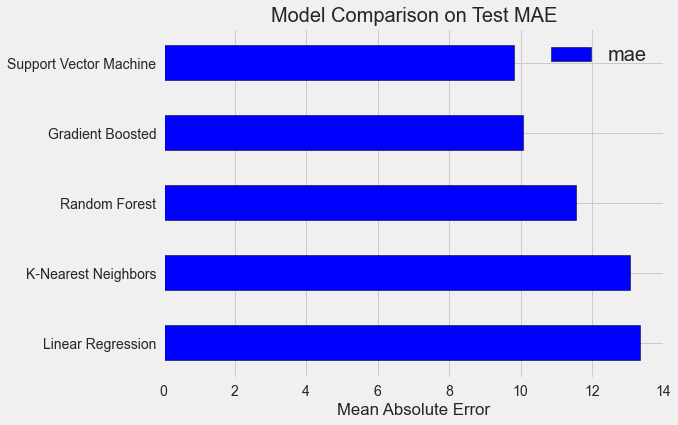

In [70]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(
    x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

Depending on the run (the exact results change slighty each time), the gradient boosting regressor performs the best followed by the random forest. I have to admit that this is not the most fair comparison because we are using mostly the default hyperparameters. Especially with the Support Vector Regressor, the hyperparameters have a significant influence on performance. (the random forest and gradient boosting methods are great for starting out because the performance is less dependent on the model settings). Nonetheless, from these results, we can conclude that machine learning is applicable because all the models significantly outperform the baseline!

From here, I am going to concentrate on optimizing the best model using hyperparamter tuning. Given the results here, I will concentrate on using the `GradientBoostingRegressor`. This is the Scikit-Learn implementation of [Gradient Boosted Trees](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf) which has won many [Kaggle competitions](http://matthewemery.ca/Why-Kagglers-Love-XGBoost/) in the past few years. The Scikit-Learn version is generally slower than the `XGBoost` version, but here we'll stick to Scikit-Learn because the syntax is more familiar. [Here's a guide](https://www.kaggle.com/dansbecker/learning-to-use-xgboost/code) to using the implementation in the `XGBoost` package.

# Model Optimization 

In machine learning, optimizing a model means finding the best set of hyperparameters for a particular problem. 

## Hyperparameters

First off, we need to understand what [model hyperparameters are in contrast to model parameters](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) :

* Model __hyperparameters__ are best thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or the number of neighbors used in K Nearest Neighbors Regression. 
* Model __parameters__ are what the model learns during training, such as the weights in the linear regression.

We as data scientists control a model by choosing the hyperparameters, and these choices can have a significant effect on the final performance of the model (although usually not as great of an effect as getting more data or engineering features). 

[Tuning the model hyperparameters](http://scikit-learn.org/stable/modules/grid_search.html) controls the balance of under vs over fitting in a model. We can try to correct for under-fitting by making a more complex model, such as using more trees in a random forest or more layers in a deep neural network. A model that underfits has high bias, and occurs when our model does not have enough capacity (degrees of freedom) to learn the relationship between the features and the target. We can try to correct for overfitting by limiting the complexity of the model and applying regularization. This might mean decreasing the degree of a polynomial regression, or adding dropout layers to a deep neural network. A model that overfits has high variance and in effect has memorized the training set. Both underfitting and overfitting lead to poor generalization performance on the test set. 

The problem with choosing the hyperparameters is that no set will work best across all problems. Therefore, for every new dataset, we have to find the best settings. This can be a time-consuming process, but luckily there are several options for performing this procedure in Scikit-Learn. Even better, new libraries, such as [TPOT](https://epistasislab.github.io/tpot/) by epistasis labs, is aiming to do this process automatically for you! For now, we will stick to doing this manually (sort of) in Scikit-Learn, but stay tuned for an article on automatic model selection! 

Model optimization is one of the toughest challenges in the implementation of machine learning solutions. Entire branches of machine learning and deep learning theory have been dedicated to the optimization of models.

Hyperparameter optimization in machine learning intends to find the hyperparameters of a given machine learning algorithm that deliver the best performance as measured on a validation set. Hyperparameters, in contrast to model parameters, are set by the machine learning engineer before training. The number of trees in a random forest is a hyperparameter while the weights in a neural network are model parameters learned during training. I like to think of hyperparameters as the model settings to be tuned so that the model can optimally solve the machine learning problem.

Some examples of model hyperparameters include:

The learning rate for training a neural network.
The C and 𝛾 hyperparameters for support vector machines.
The k in k-nearest neighbors.
Hyperparameter optimization finds a combination of hyperparameters that returns an optimal model which reduces a predefined loss function and in turn increases the accuracy on given independent data.

Hyperparameter Optimization methods
 
Hyperparameters can have a direct impact on the training of machine learning algorithms. Thus, to achieve maximal performance, it is important to understand how to optimize them. Here are some common strategies for optimizing hyperparameters:

 

1) Manual Hyperparameter Tuning
 
Traditionally, hyperparameters were tuned manually by trial and error. This is still commonly done, and experienced engineers can “guess” parameter values that will deliver very high accuracy for ML models. However, there is a continual search for better, faster, and more automatic methods to optimize hyperparameters.

 

2) Grid Search
 
Grid search is arguably the most basic hyperparameter tuning method. With this technique, we simply build a model for each possible combination of all of the hyperparameter values provided, evaluating each model, and selecting the architecture which produces the best results.
Grid-search does NOT only apply to one model type but can be applied across machine learning to calculate the best parameters to use for any given model.

For example, a typical soft-margin SVM classifier equipped with an RBF kernel has at least two hyperparameters that need to be optimized for good performance on unseen data: a regularization constant C and a kernel hyperparameter γ. Both parameters are continuous, so to perform grid search, one selects a finite set of “reasonable” values for each, let’s say
Grid search then trains an SVM with each pair (C, γ) in the cartesian product of these two sets and evaluates their performance on a held-out validation set (or by internal cross-validation on the training set, in which case multiple SVMs are trained per pair). Finally, the grid search algorithm outputs the settings that achieved the highest score in the validation procedure.

3) Random Search
 
Often some of the hyperparameters matter much more than others. Performing random search rather than grid search allows a much more precise discovery of good values for the important ones.

Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score. This allows you to explicitly control the number of parameter combinations that are attempted. The number of search iterations is set based on time or resources. Scikit Learn offers the RandomizedSearchCV function for this process.

While it’s possible that RandomizedSearchCV will not find as accurate a result as GridSearchCV, it surprisingly picks the best result more often than not and in a fraction of the time it takes GridSearchCV would have taken. Given the same resources, Randomized Search can even outperform Grid Search. This can be visualized in the graphic below when continuous parameters are used.

The chances of finding the optimal parameter are comparatively higher in random search because of the random search pattern where the model might end up being trained on the optimized parameters without any aliasing. Random search works best for lower dimensional data since the time taken to find the right set is less with less number of iterations. Random search is the best parameter search technique when there is less number of dimensions.

In the case of deep learning algorithms, it outperforms the grid search.


4) Bayesian Optimization
 
The previous two methods performed individual experiments building models with various hyperparameter values and recording the model performance for each. Because each experiment was performed in isolation, it’s very easy to parallelize this process. However, because each experiment was performed in isolation, we’re not able to use the information from one experiment to improve the next experiment. Bayesian optimization belongs to a class of sequential model-based optimization (SMBO) algorithms that allow for one to use the results of our previous iteration to improve our sampling method of the next experiment.

This, in turn, limits the number of times a model needs to be trained for validation as solely those settings that are expected to generate a higher validation score are passed through for evaluation.

Bayesian optimization works by constructing a posterior distribution of functions (Gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not.

As you iterate over and over, the algorithm balances its needs of exploration and exploitation taking into account what it knows about the target function. At each step, a Gaussian Process is fitted to the known samples (points previously explored), and the posterior distribution, combined with an exploration strategy (such as UCB (Upper Confidence Bound), or EI (Expected Improvement)), is used to determine the next point that should be explored.

Using Bayesian Optimization, we can explore the parameter space more smartly, and thus reduce the time required to do this process.

5) Gradient-based Optimization
 
It is specially used in the case of Neural Networks. It computes the gradient with respect to hyperparameters and optimizes them using the gradient descent algorithm.

The calculation of the gradient is the least of problems. At least in times of advanced automatic differentiation software. (Implementing this in a general way for all sklearn-classifiers, of course, is not easy).

And while there are works of people who used this kind of idea, they only did this for some specific and well-formulated problem (e.g. SVM-tuning). Furthermore, there probably were a lot of assumptions because:

Why is this not a good idea?

A. Hyperparameter optimization is in general non-smooth

GD really likes smooth functions as a gradient of zero is not helpful
Each hyper-parameter which is defined by some discrete-set (e.g. choice of l1 vs. l2 penalization) introduces non-smooth surfaces.

B. Hyperparameter optimization is in general non-convex

The whole convergence-theory of gradient descent assumes, that the underlying problem is convex.
Good-case: you obtain some local-minimum (can be arbitrarily bad).
Worst-case: gradient descent is not even converging to some local-minimum.

6) Evolutionary Optimization
 
Evolutionary optimization follows a process inspired by the biological concept of evolution and since natural evolution is a dynamic process in a changing environment, they are also well suited to dynamic optimization problems.

Evolutionary algorithms are often used to find good approximate solutions that cannot be easily solved by other techniques. Optimization problems often don’t have an exact solution as it may be too time-consuming and computationally intensive to find an optimal solution. However, evolutionary algorithms are ideal in such situations as they can be used to find a near-optimal solution which is often sufficient.

One advantage of evolutionary algorithms is that they develop solutions free of any human misconceptions or biases, which means they can produce surprising ideas which we might never generate ourselves.


## 6. Hyperparameter Tuning with Random Search and Cross Validation

We can choose the best hyperparameters for a model through random search and cross validation. 

* Random search refers to the method in which we choose hyperparameters to evaluate: we define a range of options, and then randomly select combinations to try. This is in contrast to grid search which evaluates every single combination we specify. Generally, random search is better when we have limited knowledge of the best model hyperparameters and we can use random search to narrow down the options and then use grid search with a more limited range of options. 
* Cross validation is the method used to assess the performance of the hyperparameters. Rather than splitting the training set up into separate training and validation sets which reduces the amount of training data we can use, we use K-Fold Cross Validation. This means dividing the training data into K folds, and then going through an iterative process where we first train on K-1 of the folds and then evaluate performance on the kth fold. We repeat this process K times so eventually we will have tested on every example in the training data with the key that each iteration we are testing on data that we __did not train on__.  At the end of K-fold cross validation, we take the average error on each of the K iterations as the final performance measure and then train the model on all the training data at once. The performance we record is then used to compare different combinations of hyperparameters. 

A picture of k-fold cross validation using k = 5 is shown below:

![image](images/kfold_cv.png)

Here we will implement random search with cross validation to select the optimal hyperparameters for the gradient boosting regressor. We first define a grid then peform an iterative process of: randomly sample a set of hyperparameters from the grid, evaluate the hyperparameters using 4-fold cross-validation, and then select the hyperparameters with the best performance. 

Of course we don't actually do this iteration ourselves, we let Scikit-Learn and `RandomizedSearchCV` do the process for us! 

In [71]:
# defining parameter range 
param_grid = {"n_estimators": np.arange(10, 5000)}
  
random_cv = RandomizedSearchCV(GradientBoostingRegressor(), param_grid, verbose = 3) 
  
# fitting the model for grid search 
random_cv.fit(X, y)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=2703 ...............................................
[CV] ................... n_estimators=2703, score=0.796, total=  43.6s
[CV] n_estimators=2703 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.5s remaining:    0.0s


[CV] ................... n_estimators=2703, score=0.807, total=  44.1s
[CV] n_estimators=2703 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] ................... n_estimators=2703, score=0.784, total=  44.4s
[CV] n_estimators=293 ................................................
[CV] .................... n_estimators=293, score=0.807, total=   5.7s
[CV] n_estimators=293 ................................................
[CV] .................... n_estimators=293, score=0.816, total=   4.7s
[CV] n_estimators=293 ................................................
[CV] .................... n_estimators=293, score=0.794, total=   5.0s
[CV] n_estimators=2643 ...............................................
[CV] ................... n_estimators=2643, score=0.797, total=  43.8s
[CV] n_estimators=2643 ...............................................
[CV] ................... n_estimators=2643, score=0.807, total=  44.1s
[CV] n_estimators=2643 ...............................................
[CV] ................... n_estimators=2643, score=0.785, total=  41.5s
[CV] n_estimators=396 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 17.8min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                       

Scikit-learn uses the negative mean absolute error for evaluation because it wants a metric to maximize. Therefore, a better score will be closer to 0. We can get the results of the randomized search into a dataframe, and sort the values by performance.

In [72]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=396,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [73]:
random_cv.best_score_

0.807085275143159

In [74]:
gradient_boosted = GradientBoostingRegressor(n_estimators=472,random_state=42)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 9.4844


The best gradient boosted model has the following hyperparameters:

* `loss = lad`
* `n_estimators = 500`
* `max_depth = 5`
* `min_samples_leaf = 6`
* `min_samples_split = 6`
* `max_features = None` (This means that `max_features = n_features` according to the docs)

Using random search is a good method to narrow down the possible hyperparameters to try. Initially, we had no idea which combination would work the best, but this at least narrows down the range of options.

We could use the random search results to inform a grid search by creating a grid with hyperparameters close to those that worked best during the randomized search. However, rather than evaluating all of these settings again, I will focus on a single one, the number of trees in the forest (`n_estimators`). By varying only one hyperparameter, we can directly observe how it affects performance. In the case of the number of trees, we would expect to see a significant affect on the amount of under vs overfitting.

Here we will use grid search with a grid that only has the `n_estimators` hyperparameter. We will evaluate a range of trees then plot the training and testing performance to get an idea of what increasing the number of trees does for our model. We will fix the other hyperparameters at the best values returned from random search to isolate the number of trees effect.

In [75]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [76]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.4min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='lad', max_depth=5,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=6,
                                                 min_samples_split=6,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
               

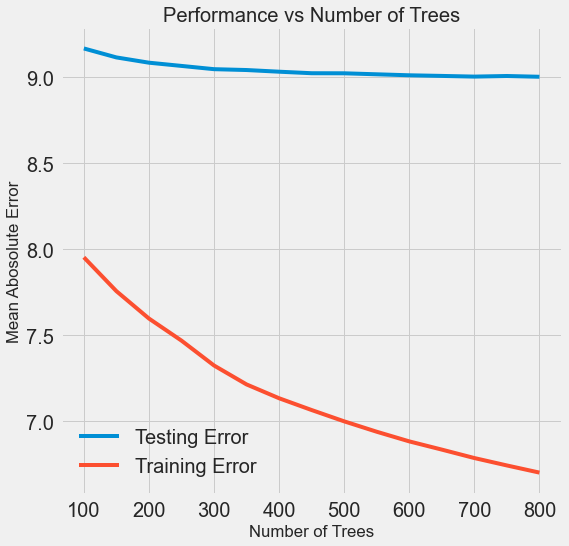

In [77]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [78]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
14,71.597300,1.854994,0.061838,0.017026,800,{'n_estimators': 800},-8.814102,-8.947157,-9.302342,-8.943682,-9.001785,0.181592,1,-6.770806,-6.876121,-6.609604,-6.553691,-6.702556,0.128047
12,64.311345,0.929351,0.084986,0.011586,700,{'n_estimators': 700},-8.809504,-8.950954,-9.309330,-8.941387,-9.002757,0.185584,2,-6.830596,-6.957426,-6.723356,-6.637054,-6.787108,0.119875
13,69.532709,1.386920,0.119323,0.052455,750,{'n_estimators': 750},-8.813517,-8.952904,-9.314484,-8.944290,-9.006262,0.186294,3,-6.801335,-6.907118,-6.663812,-6.604093,-6.744090,0.118215
11,59.840843,1.078470,0.064192,0.010348,650,{'n_estimators': 650},-8.815305,-8.954406,-9.312153,-8.945155,-9.006718,0.184688,4,-6.879397,-7.009069,-6.796861,-6.659008,-6.836084,0.127175
10,55.488146,0.886524,0.085813,0.025158,600,{'n_estimators': 600},-8.816228,-8.956790,-9.314168,-8.954514,-9.010387,0.184363,5,-6.940645,-7.032180,-6.840318,-6.722256,-6.883850,0.115364


From this plot, it's pretty clear that our model is [overfitting](https://elitedatascience.com/overfitting-in-machine-learning)! The training error is significantly lower than the testing error, which shows that the model is learning the training data very well but then is not able to generalize to the test data as well. Moveover, as the number of trees increases, the amount of overfitting increases. Both the test and training error decrease as the number of trees increase but the training error decreases more rapidly. 

There will always be a difference between the training error and testing error (the training error is always lower) but if there is a significant difference, we want to try and reduce overfitting, either by getting more training data or reducing the complexity of the model through hyperparameter tuning or regularization. [For the gradient boosting regressor](https://www.quora.com/How-do-you-correct-for-overfitting-for-a-Gradient-Boosted-Machine), some options include reducing the number of trees, reducing the max depth of each tree, and increasing the minimum number of samples in a leaf node. For anyone who wants to go further into the gradient boosting regressor, [here is a great article.](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) For now, we will use the model with the best performance and accept that it may be overfitting to the training set. 

Based on the cross validation results, the best model using 800 trees and achieves a cross validation error under 9. This indicates that the average cross-validation estimate of the Energy Star Score is within 9 points of the true answer! 

# 7. Evaluate Final Model on the Test Set

We will use the best model from hyperparameter tuning to make predictions on the testing set. Remember, our model has never seen the test set before, so this performance should be a good indicator of how the model would perform if deployed in the real world. 

For comparison, we can also look at the performance of the default model. The code below creates the final model, trains it (with timing), and evaluates on the test set. 

Model evaluation aims to estimate the generalization accuracy of a model on future (unseen/out-of-sample) data. Methods for evaluating a model's performance are divided into 2 categories: namely, holdout and Cross-validation. Both methods use a test set (i.e data not seen by the model) to evaluate model performance.

The three main metrics used to evaluate a classification model are accuracy, precision, and recall. Accuracy is defined as the percentage of correct predictions for the test data. It can be calculated easily by dividing the number of correct predictions by the number of total predictions.

“Evaluation models either describe what evaluators do or prescribe what they should do” . The evaluation model is systematic approach that will guide in measuring the efficiency and effectiveness of a training, a course or an educational program.

To evaluate how good your regression model is, you can use the following metrics:

1) R-squared: indicate how many variables compared to the total variables the model predicted. R-squared does not take into consideration any biases that might be present in the data. Therefore, a good model might have a low R-squared value, or a model that does not fit the data might have a high R-squared value.

2) Average error: the numerical difference between the predicted value and the actual value.

3) Mean Square Error (MSE): good to use if you have a lot of outliers in the data.

4) Median error: the average of all difference between the predicted and the actual values.

5) Average absolute error: similar to the average error, only you use the absolute value of the difference to balance out the outliers in the data.

6) Median absolute error: represents the average of the absolute differences between prediction and actual observation. All individual differences have equal weight, and big outliers can therefore affect the final evaluation of the model.

In [79]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [80]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

1.67 s ± 67.7 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [81]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

26.3 s ± 620 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [82]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 10.0676.
Final model performance on the test set:   MAE = 9.0464.


The final model does out-perform the baseline model by about 10%, but at the cost of significantly increased running time (it's about 12 times slower on my machine). Machine learning is often a field of tradeoffs: bias vs variance, acccuracy vs interpretability, accuracy vs running time, and the final decision of which model to use depends on the situation. Here, the increase in run time is not an impediment, because while the relative difference is large, the absolute magnitude of the training time is not significant. In a different situation, the balance might not be the same so we would need to consider what we are optimizing for and the limitations we have to work with. 

To get a sense of the predictions, we can plot the distribution of true values on the test set and the predicted values on the test set. 

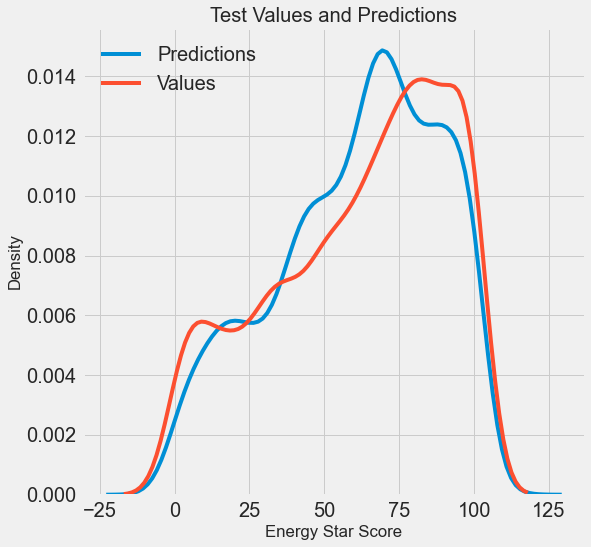

In [83]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values rather than to the actual peak at 100. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median. 

Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low). 

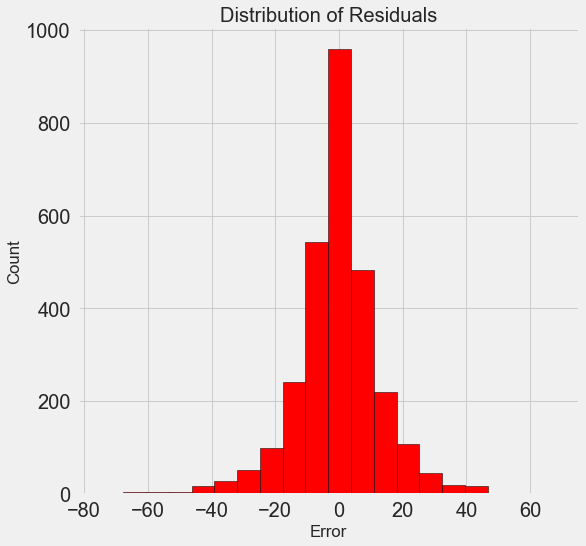

In [84]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

The residuals are close to normally disributed, with a few noticeable outliers on the low end. These indicate errors where the model estimate was far below that of the true value. 

# Conclusions

In this notebook, we covered crucial concepts in the machine learning pipeline:

* Imputing missing values
* Evaluating and comparing several machine learning methods
* Hyperparameter tuning a machine learning model using random search and cross validation
* Evaluating the best model on the testing set

The results showed us that machine learning is applicable to our problem, with the final model able to the predict the Energy Star Score of a building to within 9.1 points. We also saw that hyperparamter tuning was able to improve the performance of the model although at a considerable cost in terms of time invested. This is a good reminder that proper feature engineering and gathering more data (if possible!) has a much larger pay-off than fine-tuning the model. We also observed the trade-off in run-time versus accuracy, which is one of many considerations we have to take into account when designing machine learning models. 

We know our model is accurate, but do we know why it makes the predictions it does? The next step in the machine learning process is crucial: trying to understand how the model makes predictions. Achieveing high accuracy is great, but it would also be helpful if we could figure out why the model is able to predict accurately so we could use this information to better understand the problem. For example, what features does the model rely on to infer the Energy Star Score? It is possible to use this model for feature selection and implement a simpler model that is more interpretable? 

In the final notebook, we will try to answer these questions and draw final conclusions from the project!

In [40]:
#!pip install TPOT

In [41]:
#from tpot import TPOTRegressor

In [42]:
#tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
#tpot.fit(X, y)
#print(tpot.score(X_test, y_test))
#tpot.export('E:/Data Science class/Projects/tpot_exported_pipeline.py')